In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [20]:
dataset_path = 'Auto_MPG_data.csv'
data = pd.read_csv(dataset_path)
data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [21]:
X = data.drop(columns='MPG').values
y= data['MPG'].values

In [22]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state,shuffle=is_shuffle)
X_train, X_test , y_train, y_test= train_test_split(X_train, y_train, test_size=test_size, random_state=random_state,shuffle=is_shuffle)

In [23]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)
X_val = normalizer.transform(X_val)

In [24]:
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

In [25]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [26]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=is_shuffle)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=is_shuffle)

In [27]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [28]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [29]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [30]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true-y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [31]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

In [32]:
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print (f'\nEPOCH { epoch + 1}:\t Training loss : { train_loss :.3f} \t Validation loss : { val_loss :.3f}')


EPOCH 1:	 Training loss : 282.770 	 Validation loss : 95.335

EPOCH 2:	 Training loss : 221.920 	 Validation loss : 14.703

EPOCH 3:	 Training loss : 64.710 	 Validation loss : 61.328

EPOCH 4:	 Training loss : 56.290 	 Validation loss : 11.455

EPOCH 5:	 Training loss : 15.970 	 Validation loss : 28.503

EPOCH 6:	 Training loss : 13.479 	 Validation loss : 5.630

EPOCH 7:	 Training loss : 16.998 	 Validation loss : 31.458

EPOCH 8:	 Training loss : 19.223 	 Validation loss : 24.421

EPOCH 9:	 Training loss : 15.807 	 Validation loss : 10.720

EPOCH 10:	 Training loss : 19.937 	 Validation loss : 13.430

EPOCH 11:	 Training loss : 17.391 	 Validation loss : 7.899

EPOCH 12:	 Training loss : 11.335 	 Validation loss : 41.298

EPOCH 13:	 Training loss : 18.817 	 Validation loss : 13.712

EPOCH 14:	 Training loss : 7.896 	 Validation loss : 16.500

EPOCH 15:	 Training loss : 9.396 	 Validation loss : 6.414

EPOCH 16:	 Training loss : 7.591 	 Validation loss : 5.140

EPOCH 17:	 Training l

In [33]:
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_test, y_hat)
    print('Evaluation set R2: {:.3f}'.format(test_set_r2))

Evaluation set R2: 0.796


## NonLinear_data

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [37]:
data_path = 'NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

In [40]:
print(X.shape, y.shape)

(300, 2) (300,)


In [41]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train,X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)

In [42]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)
X_val = normalizer.transform(X_val)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
y_train = torch.tensor(y_train,dtype = torch.long)
y_val = torch.tensor(y_val,dtype = torch.long)
y_test = torch.tensor(y_test,dtype = torch.long)

In [45]:
class CustomDataset(Dataset):
    def __init__(self, X,y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.y.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [46]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=is_shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=is_shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=is_shuffle)

In [51]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dims, output_dims)
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [61]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [62]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [63]:
def compute_accuracy(y_true, y_pred):
    _, y_pred = torch.max(y_pred, dim=1)
    correct = (y_pred==y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [64]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_target, train_predict)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_target, val_predict)
    val_accs.append(val_acc)
    print (f'\nEPOCH { epoch + 1}:\t Training loss : { train_loss :.3f} \t Validation loss : { val_loss :.3f}')


EPOCH 1:	 Training loss : 0.881 	 Validation loss : 0.843

EPOCH 2:	 Training loss : 0.733 	 Validation loss : 0.818

EPOCH 3:	 Training loss : 0.707 	 Validation loss : 0.789

EPOCH 4:	 Training loss : 0.669 	 Validation loss : 0.767

EPOCH 5:	 Training loss : 0.677 	 Validation loss : 0.797

EPOCH 6:	 Training loss : 0.666 	 Validation loss : 0.723

EPOCH 7:	 Training loss : 0.652 	 Validation loss : 0.718

EPOCH 8:	 Training loss : 0.608 	 Validation loss : 0.707

EPOCH 9:	 Training loss : 0.616 	 Validation loss : 0.687

EPOCH 10:	 Training loss : 0.596 	 Validation loss : 0.668

EPOCH 11:	 Training loss : 0.577 	 Validation loss : 0.677

EPOCH 12:	 Training loss : 0.578 	 Validation loss : 0.646

EPOCH 13:	 Training loss : 0.550 	 Validation loss : 0.651

EPOCH 14:	 Training loss : 0.558 	 Validation loss : 0.610

EPOCH 15:	 Training loss : 0.530 	 Validation loss : 0.594

EPOCH 16:	 Training loss : 0.525 	 Validation loss : 0.593

EPOCH 17:	 Training loss : 0.519 	 Validation lo

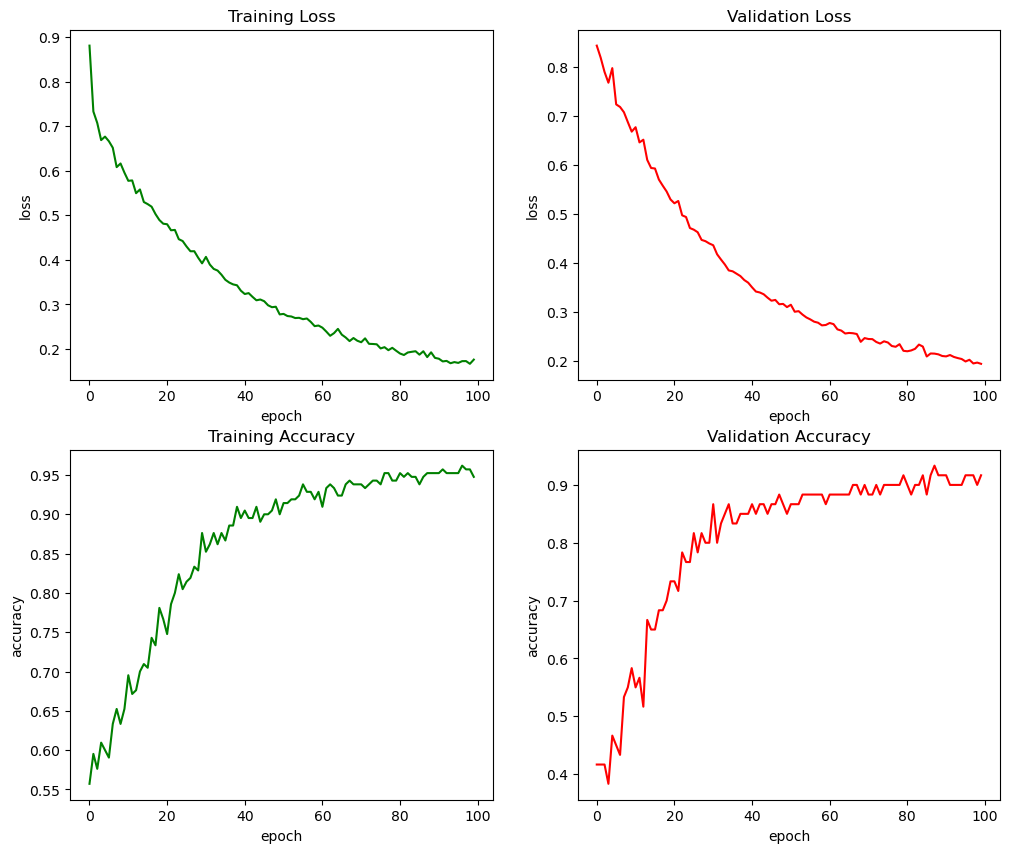

In [67]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(train_losses, color='green')
ax[0,0].set(xlabel='epoch', ylabel='loss')
ax[0,0].set_title('Training Loss')

ax[0,1].plot(val_losses, color='red')
ax[0,1].set(xlabel='epoch', ylabel='loss')
ax[0,1].set_title('Validation Loss')

ax[1,0].plot(train_accs, color='green')
ax[1,0].set(xlabel='epoch', ylabel='accuracy')
ax[1,0].set_title('Training Accuracy')

ax[1,1].plot(val_accs, color='red')
ax[1,1].set(xlabel='epoch', ylabel='accuracy')
ax[1,1].set_title('Validation Accuracy')

plt.show()

In [68]:
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_target, test_predict)
    print('Test Accuracy:', test_acc)

Test Accuracy: 0.9


In [69]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [71]:
train_dir = 'FER-2013/train'
test_dir = 'FER-2013/test'

classes = os.listdir(train_dir)
label_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_label = {idx: cls for cls, idx in label_to_idx.items()}